<a href="https://colab.research.google.com/github/macorony/Convolutional-Network/blob/main/densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Understanding DenseNet: Architecture and Advantages
DenseNet, short for Dense Convolutional Network, is a CNN architecture known for its unique connectivity pattern, which aims to maximize information flow between layers. Unlike traditional architectures where each layer connects only to its subsequent layer, DenseNet directly connects each layer to every other layer in a feed-forward fashion.

## Dense Connectivity: Fostering Feature Reuse and Information Flow

1. In a DenseNet with L layers, there are L(L+1)/2 direct connections. Each layer receives the feature maps from all preceding layers as input, and its own feature maps are passed as input to all subsequent layers.

2. This dense connectivity offers several advantages:
  *  Alleviates the vanishing gradient problem: Direct connections to the loss function and original input signal provide each layer with clear gradients, facilitating training of deeper networks. This is similar to the concept of "deep supervision".
  
  *  Strengthens feature propagation: Information flows more efficiently throughout the network due to the short paths created by dense connections.
  
  *  Encourages feature reuse: Layers have access to features learned at different levels of the network, promoting the learning of compact and efficient representations.

## Structure of DenseNet: Dense Blocks and Transition Layers
DenseNets are typically organized into dense blocks interconnected by transition layers.
* Dense Block: Within a dense block, layers are densely connected as described above. Each layer adds a small set of feature maps (k feature maps, where k is the growth rate) to the network's "collective knowledge".

* Transition Layer: Transition layers are placed between dense blocks to change feature map sizes via convolution and pooling. They help to control the network's complexity and reduce the number of feature maps.
  * Compression: To further reduce the number of parameters, DenseNet-C employs a compression factor (θ) in transition layers to reduce the number of output feature maps.
  
  * Bottleneck Layers: DenseNet-BC introduces 1x1 convolutions (bottleneck layers) before each 3x3 convolution in dense blocks to further reduce computational complexity.

## Key Features and Design Choices:
* Growth rate (k): This hyperparameter controls the number of feature maps added by each layer. A smaller growth rate results in narrower layers, leading to a more compact model.

* Bottleneck and Compression: These techniques aim to improve model compactness and efficiency. DenseNet-BC combines both bottleneck layers and compression in transition layers.

* Composite Function: Each layer's transformation in DenseNet often consists of batch normalization, ReLU activation, and a 3x3 convolution.
Performance and Efficiency:

* Experiments show that DenseNets can achieve high accuracy with fewer parameters compared to other architectures, particularly ResNets.

* The dense connectivity pattern enables efficient feature reuse and information flow, contributing to better performance and easier training.

* Memory-efficient implementations are important for practical use, especially on GPUs.

## Connection to Other Architectures:
* ResNets: DenseNet draws inspiration from ResNets' use of skip connections to improve information flow. However, DenseNet concatenates features instead of summing them, potentially mitigating information loss.

* Stochastic Depth: There's an intriguing link between DenseNet and stochastic depth regularization in ResNets, as both create direct connections between non-adjacent layers.

* Inception Networks: Like Inception networks, DenseNets concatenate features from different layers, but they are simpler and more efficient.


## Conclusion:
DenseNet offers a compelling approach to CNN design, emphasizing feature reuse and efficient information flow through dense connectivity. Its ability to achieve high accuracy with fewer parameters makes it an attractive choice for various computer vision tasks.


***resource paper***: https://arxiv.org/abs/1608.06993v5

## Implementation

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class TransitionLayer(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(TransitionLayer, self).__init__()
    self.transition = nn.Sequential(
        nn.BatchNorm2d(in_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
        nn.AvgPool2d(kernel_size=2, stride=2)
    )
  def forward(self, x):
    return self.transition(x)

In [ ]:
# define a transitionlayer
transition_layer = TransitionLayer(128, 64)
sample_input = torch.randn(1, 128, 32, 32)
sample_output = transition_layer(sample_input)
print(sample_output.shape)

torch.Size([1, 64, 16, 16])


In [ ]:
class DenseLayer(nn.Module):
  def __init__(self, in_channels, growth_rate, bn_size=4):
    super(DenseLayer, self).__init__()
    # 1x1 bottleneck layer
    self.bn1 = nn.BatchNorm2d(in_channels)
    self.relu = nn.ReLU(inplace=True)
    self.conv1 = nn.Conv2d(in_channels, bn_size * growth_rate,
                           kernel_size=1, stride=1, bias=False)

    # 3x3 bottleneck layer
    self.bn2 = nn.BatchNorm2d(bn_size * growth_rate)
    self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3,
                              stride=1, padding=1, bias=False)
  def forward(self, x):
    out = self.conv1(self.relu(self.bn1(x)))
    out = self.conv2(self.relu(self.bn2(out)))
    return torch.cat([x, out], dim=1)

In [ ]:
in_channels = 64
growth_rate = 32
dense_layer = DenseLayer(in_channels, growth_rate=32)
sample_input = torch.randn(1, in_channels, 32, 32)
output = dense_layer(sample_input)
print(output.shape)

torch.Size([1, 96, 32, 32])


## Dense Layer Architecture

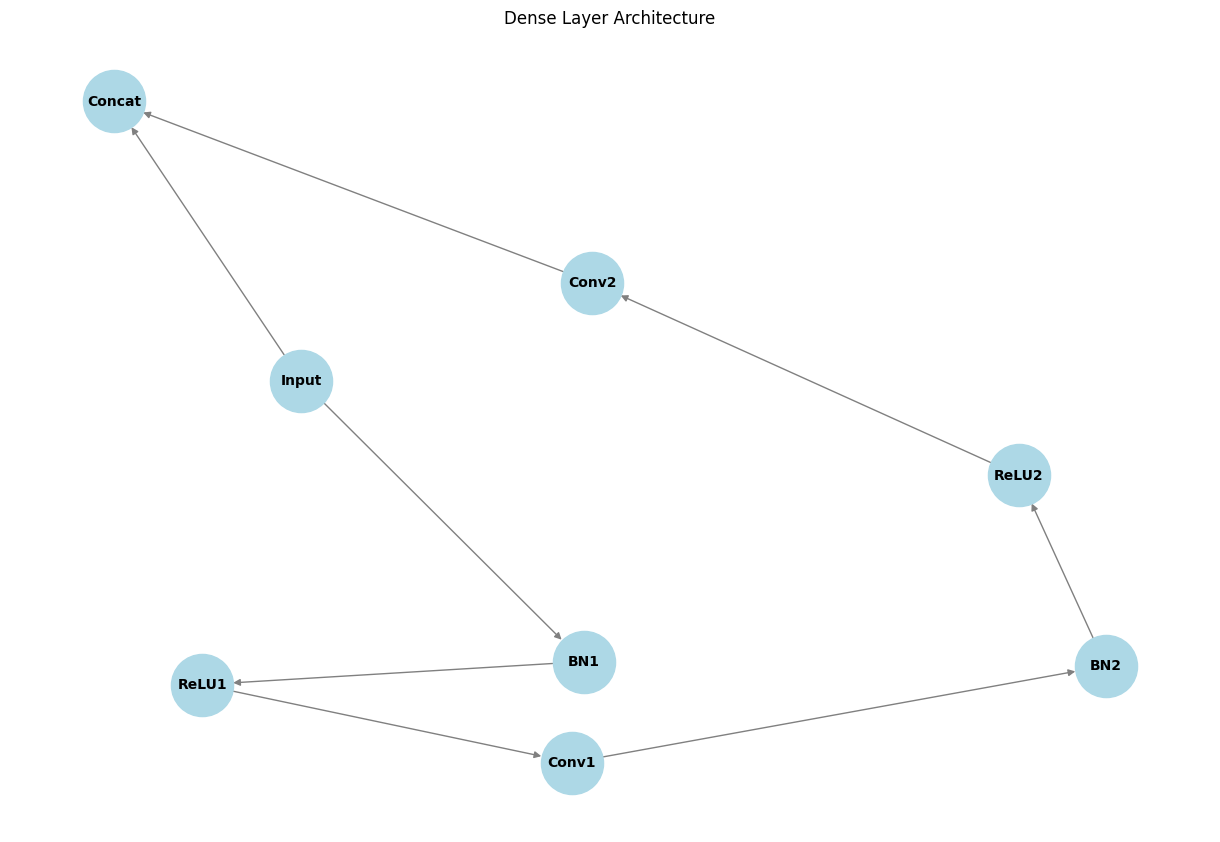

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
def create_densenet():
  G = nx.DiGraph()
  # build nodes
  nodes = ['Input', 'BN1', 'ReLU1', 'Conv1',
           'BN2', 'ReLU2', 'Conv2', 'Concat']
  G.add_nodes_from(nodes)
  # build edges
  edges = [('Input','BN1'),
           ('BN1', 'ReLU1'),
           ('ReLU1', 'Conv1'),
           ('Conv1', 'BN2'),
           ('BN2', 'ReLU2'),
           ('ReLU2', 'Conv2'),
           ('Conv2', 'Concat'),
           ('Input', 'Concat')
           ]
  G.add_edges_from(edges)
  # Create Layout
  pos = nx.spring_layout(G)

  # plot
  plt.figure(figsize=(12,8))
  nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10,
          font_weight='bold', arrows=True, edge_color='gray')
  plt.title('Dense Layer Architecture')
  plt.show()

create_densenet()


In [ ]:
class DenseBlock(nn.Module):
  def __init__(self, num_layers, in_channels, growth_rate, bn_size):
    super(DenseBlock, self).__init__()
    self.layers = nn.ModuleList([
        DenseLayer(in_channels + i*growth_rate, growth_rate, bn_size)
        for i in range(num_layers)
        ])
    def forward(self, x):
      for layer in self.layers:
        x = layer(x)
      return x

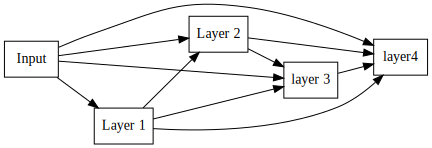

In [ ]:
from graphviz import Digraph
def create_denseblock_chart():
  graph = Digraph(comment='DenseBlock Structure')
  graph.attr(rankdir='LR')
  # Add nodes
  graph.node('input', 'Input', shape='box')
  graph.node('layer1', 'Layer 1', shape='box')
  graph.node('layer2', 'Layer 2', shape='box')
  graph.node('layer3', 'layer 3', shape='box')
  graph.node('layer4', 'layer4', shape='box')

  # Add edges
  # start with input
  graph.edge('input', 'layer1')
  graph.edge('input', 'layer2')
  graph.edge('input', 'layer3')
  graph.edge('input', 'layer4')
  # start with layer1
  graph.edge('layer1', 'layer2')
  graph.edge('layer1', 'layer3')
  graph.edge('layer1', 'layer4')
  # start with layer2
  graph.edge('layer2', 'layer3')
  graph.edge('layer2', 'layer4')
  # start with layer3
  graph.edge('layer3', 'layer4')
  return graph

flowchart = create_denseblock_chart()
flowchart


## Connectivity within DenseNet
1. Dense Connectivity:
  * Each layer receives input from ALL preceding layers
  * The feature maps from all previous layers are concatenated together
  * This creates short paths for information and gradient flow
2. Key Benefit:
  * Stronger feature propagation
  * Encourages feature reuse
  * Reduces number of parameters
  * Alleviates vanishing gradient problems
3. Growth Rate:
  * Each layer produces k new feature maps (k is the growth rate)
  * Small growth rates work well as each layer can acess all previous feature maps
4. Connectivity implementation
  * The connection between different layers is primarily achieved through the concatenation operation in the DenseLayer's forward method.
  * When construct DenseLayer in the DenseBlock's forward method, the for loop will accumulate these conncections

In [ ]:
# torch.cat
sample_input = torch.randn(3,6,32,32)
sample_output = torch.randn(3,2,32,32)
torch.cat([sample_input, sample_output], dim=1).shape
# Connection within DenseBlock
class SimpleDenseLayer(nn.Module):
  def __init__(self, in_channels, growth_rate):
    super(SimpleDenseLayer, self).__init__()
    self.conv = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1)
  def forward(self, x):
    conv_out = self.conv(x)
    out = torch.cat([x, conv_out], dim=1)
    print(f'The dimension of the input is {x.shape}')
    print(f'The dimension of the convolutional output is {conv_out.shape}')
    print(f'The dimension of the concatenated output is {out.shape}')
    return out

layer1 = SimpleDenseLayer(3, 2)
sample_input = torch.randn(3,3,32,32)
sample_output = layer1(sample_input)

The dimension of the input is torch.Size([3, 3, 32, 32])
The dimension of the convolutional output is torch.Size([3, 2, 32, 32])
The dimension of the concatenated output is torch.Size([3, 5, 32, 32])


In [ ]:
def demonstrate_connections():
  input = torch.randn(3,3,32,32)
  growth_rate = 2
  layer1 = SimpleDenseLayer(3,2)
  layer2 = SimpleDenseLayer(5,2)
  layer3 = SimpleDenseLayer(7,2)

  print(f'The initial input shape is {input.shape}')

  output1 = layer1(input)
  print(f'The layer 1 output shape is {output1.shape}')
  output2 = layer2(output1)
  print(f'The layer 2 output shape is {output2.shape}')
  output3 = layer3(output2)
  print(f'The layer 3 output shape is {output3.shape}')

demonstrate_connections()

The initial input shape is torch.Size([3, 3, 32, 32])
The dimension of the input is torch.Size([3, 3, 32, 32])
The dimension of the convolutional output is torch.Size([3, 2, 32, 32])
The dimension of the concatenated output is torch.Size([3, 5, 32, 32])
The layer 1 output shape is torch.Size([3, 5, 32, 32])
The dimension of the input is torch.Size([3, 5, 32, 32])
The dimension of the convolutional output is torch.Size([3, 2, 32, 32])
The dimension of the concatenated output is torch.Size([3, 7, 32, 32])
The layer 2 output shape is torch.Size([3, 7, 32, 32])
The dimension of the input is torch.Size([3, 7, 32, 32])
The dimension of the convolutional output is torch.Size([3, 2, 32, 32])
The dimension of the concatenated output is torch.Size([3, 9, 32, 32])
The layer 3 output shape is torch.Size([3, 9, 32, 32])


In [6]:
class DenseNet(nn.Module):
  def __init__(self, growth_rate=32, block_config=(6,12,24,16), num_init_features=64, bn_size=4, compression=0.5, num_classes=1000):
    super(DenseNet, self).__init__()
    # first convolutional layer
    self.features = nn.Sequential(
        nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False),
        nn.BatchNorm2d(num_init_features),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )
    # dense blocks
    num_features = num_init_features
    for i, num_layers in enumerate(block_config):
      block = DenseBlock(num_layers, num_features, growth_rate, bn_size)
      self.features.add_module(f'denseblock{i+1}', block)
      num_features += num_layers * growth_rate

      if i != len(block_config) - 1:
        num_out_features = int(num_features * compression)
        trans = TransitionLayer(num_features, num_out_features)
        self.features.add_module(f'transition{i+1}', trans)
        num_features = num_out_features

    # final batch norm and classifier
    self.features.add_module('final_bn', nn.BatchNorm2d(num_features))
    self.classifier = nn.Linear(num_features, num_classes)

  def forward(self, x):
    features = self.features(x)
    out = F.relu(features, inplace=True)
    out = F.avg_pool2d(out, kernel_size=7, stride=1).view(features.size(0), -1)
    out = self.classifier(out)
    return out


## Breakdown of `num_features += num_layers * growth_rate`
1. `num_features`: This variable keeps tracks of the number of input feature channels in the for loop build blocks with different layer numbers.
2. `num_layers`: Pre-defined parameters that controls how many layers within each block.
3. `growth_rate`: A universal hyperparameter across different blocks determines how many new features generated after each dense layer. however, the growth rate can be set as a random number within a specific range. This can be a useful technique for experimenting with different network configuration and finding a potentially optimal growth rate.

## How the growth rate impact the network performance

1. **Model Capacity**: The growth rate directly determines the number of feature maps (channels) produced by each dense layer. A higher growth rate leads to a larger overall model capacity, as more feature maps are concatenated at each transition layer. This increased capacity allows the model to learn more complex representations.

2. **Parameter Efficiency**: While a higher growth rate increases model capacity, it also increases the total number of parameters in the model. This can lead to higher memory and computational requirements during training and inference. Finding the right balance between capacity and parameter efficiency is important.

3. **Representational Power**: The growth rate affects the model's ability to capture different types of features. A higher growth rate allows the model to learn more diverse and specialized features, which can improve performance on complex tasks. However, too high of a growth rate may lead to overfitting.

4. **Convergence Speed**: The growth rate can impact the training convergence speed. A lower growth rate generally leads to slower convergence, as the model has less capacity to fit the training data. Conversely, a higher growth rate may cause the model to converge faster but potentially overfit.

5. **Inference Latency**: A higher growth rate results in a larger model size, which can increase the inference latency, especially on resource-constrained devices. This is an important consideration for real-time or embedded applications.

6. **Generalization**: The growth rate can affect the model's ability to generalize to new, unseen data. A growth rate that is too high may lead to overfitting, while a rate that is too low may limit the model's ability to learn the necessary representations.

In practice, the optimal growth rate often needs to be determined empirically, as it depends on factors such as the dataset size and complexity, the desired model performance, and the available computational resources. Common growth rates used in DenseNet range from 12 to 32, but the best value can vary significantly based on the specific use case.


## Pre-activation

The order of operations in the transition layer (BN → ReLU → Conv rather than Conv → BN → ReLU) follows a principle called "pre-activation" that was introduced in the paper "Identity Mappings in Deep Residual Networks" by He et al.
Here are the key reasons:

* Better Gradient Flow

  * When the activation (ReLU) comes before the convolution, it helps prevent the gradients from vanishing during backpropagation
  * The pre-activation ensures that the gradient can flow through the network without being diminished by dying ReLU units and network can recover even if some ReLU units are initially dead

* Better Regularization
  * Batch normalization before ReLU helps normalize the input distribution before applying the non-linearity
  * This makes the optimization landscape smoother and helps with training

* Improved Feature Refinement
  * The normalized and activated features are then processed by the convolution layer
  * This means the convolution layer receives cleaner, more stable inputs to work with

In [2]:
for i in range(6):
  print(i)

0
1
2
3
4
5
